In [109]:
#!pip install pytorch-tabnet wget
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn import tree
from xgboost import plot_tree
import pandas as pd
import numpy as np
import os
import wget
from pathlib import Path
import shutil
import gzip
import joblib
import pydot

random_state=42
np.random.seed(random_state)

from matplotlib import pyplot as plt

In [110]:
#Display information about dataframe
def displayInformationDataFrame(df_cop):
    summary_df = pd.DataFrame(columns=['Data Type', 'Column Name', 'Unique Values'])
    # Iterate through the columns of the original dataframe
    for col in df_cop.columns:
        # Get the data type of the column
        dtype = df_cop[col].dtype
        # Get the column name
        col_name = col
        # Get the unique values of the column
        unique_values = df_cop[col].unique()
        # Append a new row to the summary dataframe
        summary_df = summary_df.append({'Data Type': dtype, 'Column Name': col_name, 'Unique Values': unique_values}, ignore_index=True)
    # display the summary_df
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    return display(summary_df)

def calcula_metricas(nome_modelo, ground_truth, predicao):
    """
      Funcão Auxiliar para calcular e imprimir métricas: Tx de Acerto, F1, 
      Precisão, Sensibilidade e AUC
    """
    acc = accuracy_score(y_true = ground_truth, y_pred = predicao)
    f1 = f1_score(y_true = ground_truth, y_pred = predicao,average='weighted')
    precision = precision_score(y_true = ground_truth, y_pred = predicao,average='weighted')
    recall = recall_score(y_true = ground_truth, y_pred = predicao,average='weighted')
    #auc_sklearn = roc_auc_score(y_true = ground_truth, y_score = predicao, multi_class='ovr')

    print(f"Desempenho {nome_modelo} - Conjunto de Teste")
    print(f' Taxa de Acerto: {np.round(acc*100,2)}%\n Precisão: {np.round(precision*100,2)}%')
    print(f' Sensibilidade: {np.round(recall*100,2)}%\n Medida F1: {np.round(f1*100,2)}%')
    #print(f' Área sob a Curva: {np.round(auc_sklearn*100,2)}%')
    
def fix_data_mixed_types(df, mixed_columns):    
    # Loop over the mixed columns and clean them
    for col_name in mixed_columns:
        dtype_before = df[col_name].dtype
        
        # Convert non-numeric values to NaN and replace with mean
        df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
        mean = df[col_name].mean()
        df[col_name].fillna(mean, inplace=True)
        
        dtype_after = df[col_name].dtype
        print(f"[INFO] Before: {dtype_before} | After: {dtype_after}")
        
    return df
  


In [111]:
df = pd.read_csv('../../../data/2022_combined.csv', low_memory=False)
drop_columns = ['uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p']

df.drop(drop_columns, axis=1, inplace=True)
df.dropna(axis=0, how='any', inplace=True)
df.drop_duplicates(subset=None, keep="first", inplace=True)
df = shuffle(df)

In [112]:
categorical_columns = []
for col in df.columns[df.dtypes == object]:
    if col != "type":
        categorical_columns.append(col)
        
print(categorical_columns)
print(df.columns)

['service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'history', 'flow_duration']
Index(['proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes',
       'resp_pkts', 'resp_ip_bytes', 'flow_duration', 'fwd_pkts_tot',
       'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot',
       'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec',
       'down_up_ratio', 'fwd_header_size_tot', 'fwd_header_size_min',
       'fwd_header_size_max', 'bwd_header_size_tot', 'bwd_header_size_min',
       'bwd_header_size_max', 'flow_FIN_flag_count', 'flow_SYN_flag_count',
       'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count',
       'flow_ACK_flag_count', 'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
       'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.std',
       'bwd_pkts_payload.min', 'bwd_pkts_payload.max', 'bwd_pkts_payload.tot',
       'bwd_pkts_payload.a

In [113]:
featuresFromStart = [ col for col in df.columns if col not in ["type"]]

    
displayInformationDataFrame(df)

,Data Type,Column Name,Unique Values
0,int64,proto,"[6, 17, 1]"
1,object,service,"[-, http, ntp, dns, ssl, dtls, dhcp, radius]"
2,object,duration,"[1.021884, 100.861586, 62.291705, 0.550933, 0...."
3,object,orig_bytes,"[0, 1035134718, 2290, 520, 353, 335081349, 494..."
4,object,resp_bytes,"[0, 294, 47, 48, 256, 148, 108, 32, 23, 66, 11..."
5,object,conn_state,"[S0, OTH, S1, RSTO, SF, REJ, RSTR, SH, RSTOS0,..."
6,int64,missed_bytes,"[0, 1437883982, 563698303, 417612725, 94698534..."
7,object,history,"[S, D, -, Sh, DaT, ShR, ShADa, ShADadtFf, ShAD..."
8,int64,orig_pkts,"[2, 5, 3, 1, 10, 6, 9, 21, 4, 15, 8, 14, 7, 13..."
9,int64,orig_ip_bytes,"[120, 140, 40, 3083, 80, 168, 788, 717, 84, 65..."


In [115]:
def history_to_int(history):
    hist_list = list(history)
    sum = 0
    mapping = {'s': 1, 'S': 2, 'h': 3, 'H': 4, 'a': 5, 'A': 6, 'd': 7, 'D': 8, 'f': 9, 'F': 10, 'r': 11, 'R': 12, 'c': 13, 'C': 14, 'g': 15, 'G': 16, 't': 17, 'T': 18, 'w': 19, 'W': 20, 'i': 21, 'I': 22, 'q': 23, 'Q': 24, '^': 25}
    for char in hist_list:
        sum = sum + mapping.get(char,0)
    return sum

df['flow_duration'] = df['flow_duration'].str.replace(',','.')
df['flow_duration'] = df['flow_duration'].astype(float)


df = fix_data_mixed_types(df, ['duration','resp_bytes','orig_bytes'])
"""

df['duration'] = df['duration'].str.replace('-','0')
df['duration'] = df['duration'].str.replace(',','.')
df['duration'] = df['duration'].astype(float)

df['resp_bytes'] = df['resp_bytes'].str.replace('-','0')
df['resp_bytes'] = df['resp_bytes'].astype(int)

df['orig_bytes'] = df['orig_bytes'].str.replace('-','0')
df['orig_bytes'] = df['orig_bytes'].astype(int)
"""
df['history'] = df.apply(lambda row: history_to_int(row['history']), axis=1)

In [116]:
categorical_columns = []
for col in df.columns[df.dtypes == object]:
    if col != "type":
        categorical_columns.append(col)
        
print(categorical_columns)
print(df.columns)

['service', 'conn_state']
Index(['proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes',
       'resp_pkts', 'resp_ip_bytes', 'flow_duration', 'fwd_pkts_tot',
       'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot',
       'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec',
       'down_up_ratio', 'fwd_header_size_tot', 'fwd_header_size_min',
       'fwd_header_size_max', 'bwd_header_size_tot', 'bwd_header_size_min',
       'bwd_header_size_max', 'flow_FIN_flag_count', 'flow_SYN_flag_count',
       'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count',
       'flow_ACK_flag_count', 'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
       'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.std',
       'bwd_pkts_payload.min', 'bwd_pkts_payload.max', 'bwd_pkts_payload.tot',
       'bwd_pkts_payload.avg', 'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_p

In [117]:
df["history"].unique()

array([  2,   8,   0,   5,  31,  17,  24,  67,  80,  97,  62,  18,  36,
        43,  15,  42,  50,  21,  13,  56,  61,  32,  38,   4,  63,  68,
        10,  53,  60,  19,  29,  23,  54,  85,  11,  71,  26,   7,  69,
        47,  79,  45,  12,  33,  30,  74,  86,  14,  57,  44,  25,  78,
        27,  37,  49,  22,  48,   6,  65, 115,  41,  66, 128,  35,  73,
       104,  58,  75,  34,  76,  72,  96,  52,  64,  87,  40,  28,  91,
        98,  81,  20,  55,  89])

In [118]:
colunas_one_hot = {}
for coluna in categorical_columns:
    codes, uniques = pd.factorize(df[coluna].unique())
    colunas_one_hot[coluna] = {"uniques": uniques, "codes":codes}
    df[coluna] = df[coluna].replace(colunas_one_hot[coluna]["uniques"], colunas_one_hot[coluna]["codes"])
    print(coluna)
df = pd.get_dummies(data=df, columns=categorical_columns)
displayInformationDataFrame(df)

service
conn_state


,Data Type,Column Name,Unique Values
0,int64,proto,"[6, 17, 1]"
1,float64,duration,"[1.021884, 100.861586, 62.291705, 0.550933, 0...."
2,int64,orig_bytes,"[0, 1035134718, 2290, 520, 353, 335081349, 494..."
3,int64,resp_bytes,"[0, 294, 47, 48, 256, 148, 108, 32, 23, 66, 11..."
4,int64,missed_bytes,"[0, 1437883982, 563698303, 417612725, 94698534..."
5,int64,history,"[2, 8, 0, 5, 31, 17, 24, 67, 80, 97, 62, 18, 3..."
6,int64,orig_pkts,"[2, 5, 3, 1, 10, 6, 9, 21, 4, 15, 8, 14, 7, 13..."
7,int64,orig_ip_bytes,"[120, 140, 40, 3083, 80, 168, 788, 717, 84, 65..."
8,int64,resp_pkts,"[0, 1, 10, 4, 7, 3, 20, 16, 2, 13, 14, 12, 11,..."
9,int64,resp_ip_bytes,"[0, 44, 532, 216, 872, 172, 1155, 911, 112, 80..."


In [119]:
df = shuffle(df)
n_total = len(df)

features = [ col for col in df.columns if col not in ["type"]] 

le = LabelEncoder()
le.fit(df["type"].values)

train_val_indices, test_indices = train_test_split(range(n_total), test_size=0.2, random_state=random_state)
#train_indices, valid_indices = train_test_split(train_val_indices, test_size=0.25, random_state=random_state) # 0.25 x 0.8 = 0.2

X_train = df[features].values[train_val_indices]
y_train = df["type"].values[train_val_indices]
y_train = le.transform(y_train)

#X_valid = df[features].values[valid_indices]
#y_valid = df["Attack_type"].values[valid_indices]
#y_valid = le.transform(y_valid)

X_test = df[features].values[test_indices]
y_test = df["type"].values[test_indices]
y_test = le.transform(y_test)

standScaler = StandardScaler()
model_norm = standScaler.fit(X_train)

X_train = model_norm.transform(X_train)
X_test = model_norm.transform(X_test)

              precision    recall  f1-score   support

           0       0.41      0.22      0.29       303
           1       0.00      0.00      0.00         2
           2       0.27      0.27      0.27       242
           3       0.98      0.99      0.98      9746
           4       1.00      1.00      1.00      5908
           5       0.99      0.99      0.99     13366
           6       0.76      0.73      0.75      2315
           7       0.61      0.71      0.65      1028
           8       0.91      0.95      0.93      1461
           9       1.00      1.00      1.00     22128

    accuracy                           0.97     56499
   macro avg       0.69      0.69      0.69     56499
weighted avg       0.97      0.97      0.97     56499

Elements wrong classified: 1679; Elements correct: 54820


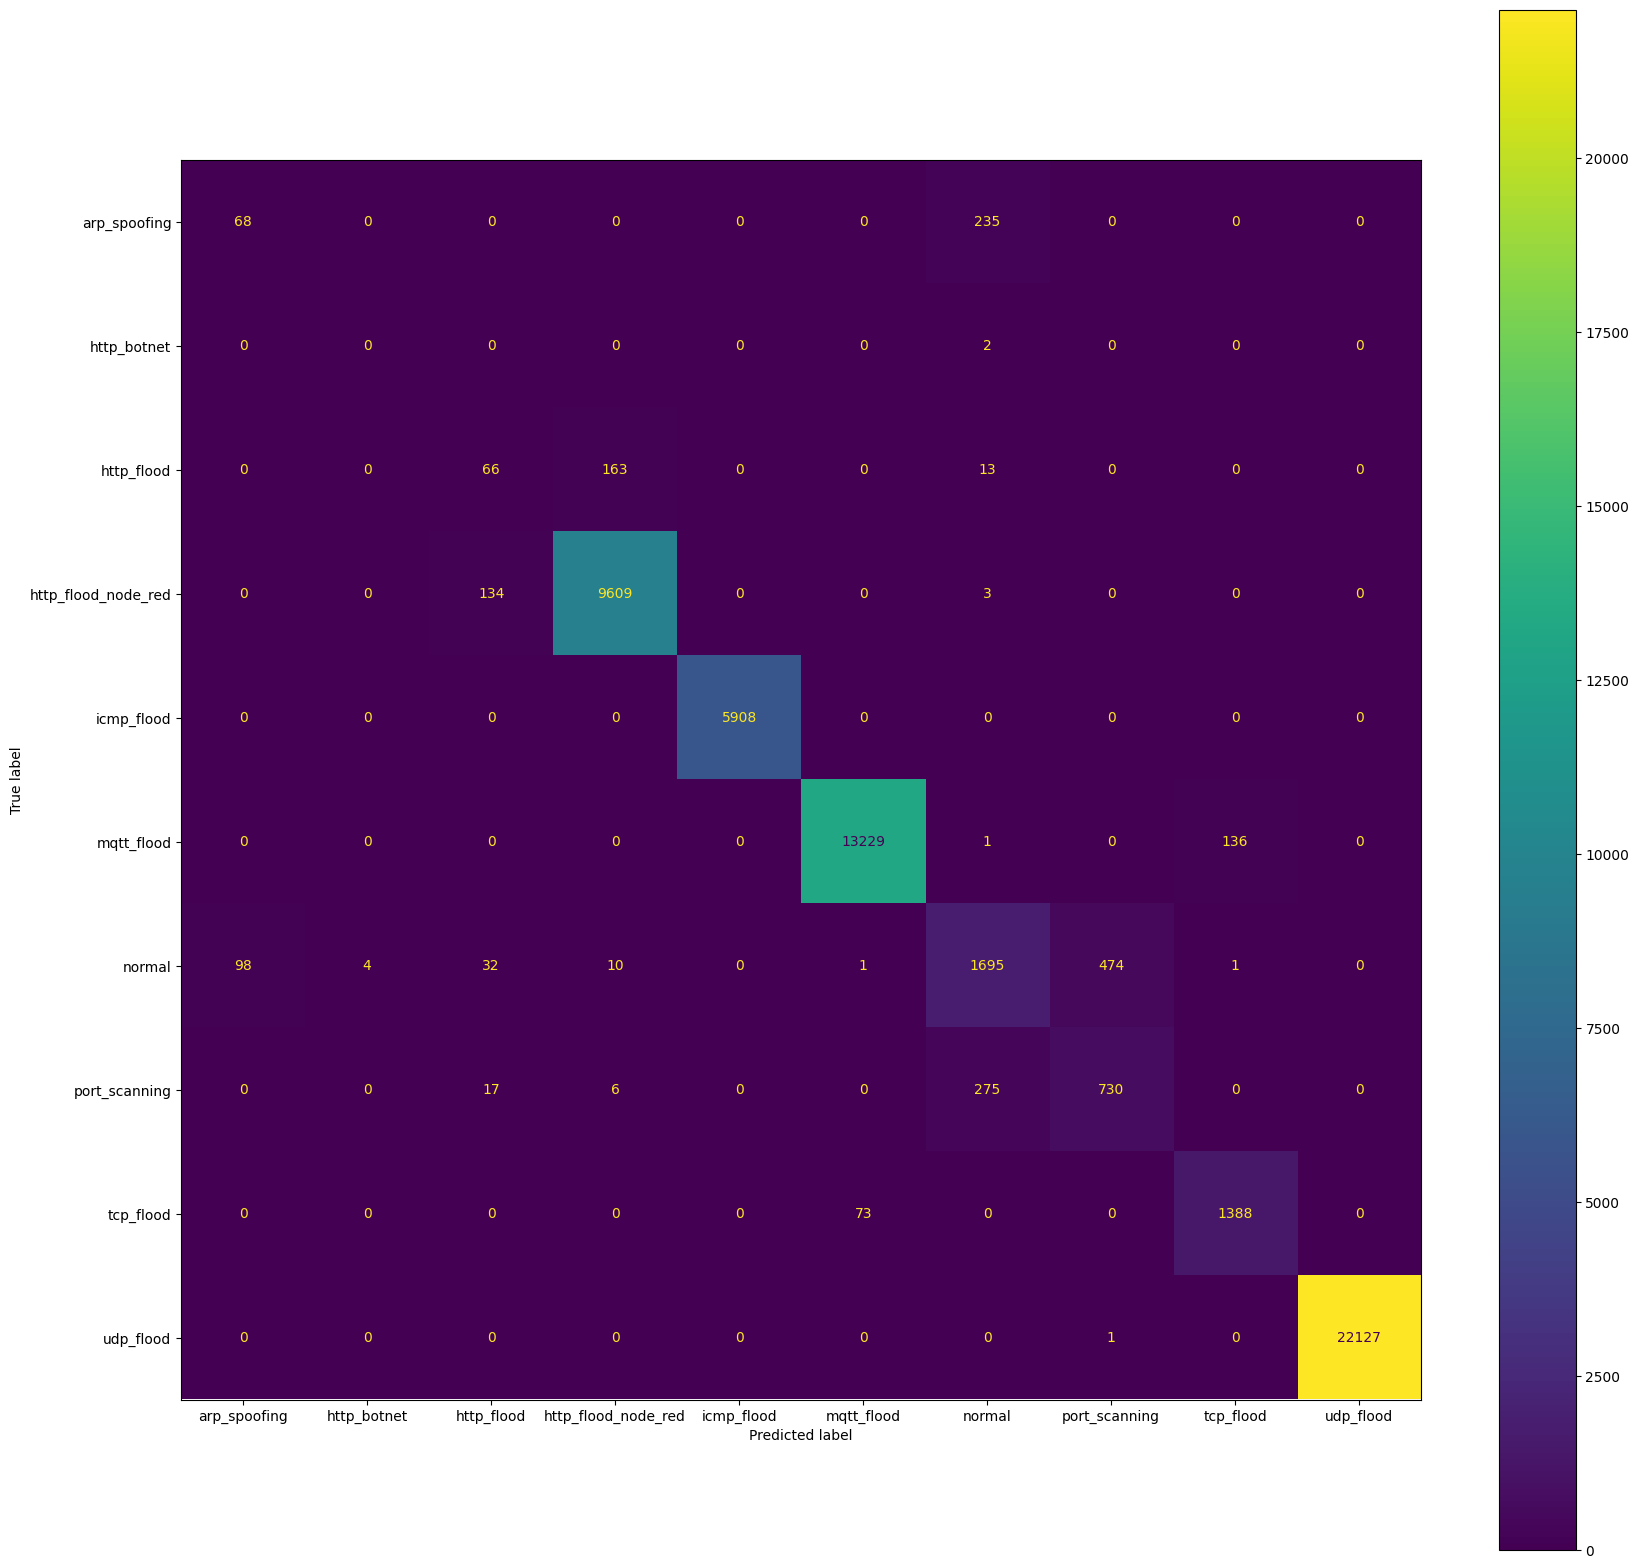

Desempenho Random Forest - Conjunto de Teste
 Taxa de Acerto: 97.03%
 Precisão: 96.99%
 Sensibilidade: 97.03%
 Medida F1: 96.99%
              precision    recall  f1-score   support

           0       0.41      0.22      0.29       303
           1       0.00      0.00      0.00         2
           2       0.27      0.27      0.27       242
           3       0.98      0.99      0.98      9746
           4       1.00      1.00      1.00      5908
           5       0.99      0.99      0.99     13366
           6       0.76      0.73      0.75      2315
           7       0.61      0.71      0.65      1028
           8       0.91      0.95      0.93      1461
           9       1.00      1.00      1.00     22128

    accuracy                           0.97     56499
   macro avg       0.69      0.69      0.69     56499
weighted avg       0.97      0.97      0.97     56499

balanced_accuracy
0.6865129966676656


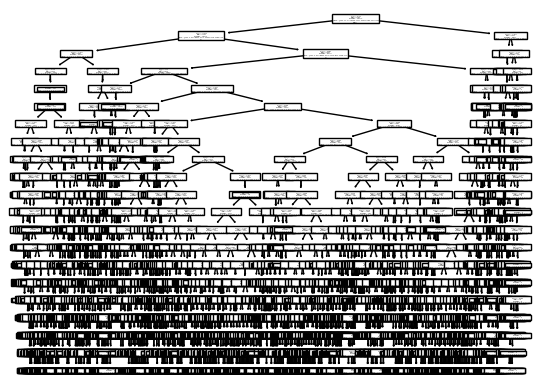

In [120]:
# Instantiate model with 1000 decision trees
clf = tree.DecisionTreeClassifier(max_depth=20, random_state = random_state)#,n_estimators = 10)
# Train the model on training data
clf.fit(X_train, y_train)

joblib.dump(clf, "./modelDecisionTree.joblib")
#loaded_rf = joblib.load("./random_forest.joblib")

predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

mask = np.logical_not(np.equal(y_test, predictions))
print(f"Elements wrong classified: {len(X_test[mask])}; Elements correct: {len(X_test) - len(X_test[mask])}")

original_labels_list = le.classes_
fig,ax = plt.subplots(figsize=(20, 20))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels= original_labels_list)
cm_display.plot(ax=ax)
plt.savefig("confusion_matrix.png")
plt.show()

calcula_metricas("Random Forest", y_test, predictions)

# Pull out one tree from the forest
tre = tree.plot_tree(clf)
# Export the image to a dot file
#dot_data = tree.export_graphviz(clf, out_file='treeMulti.dot', feature_names = features, rounded = True, precision = 1)
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('treeMulti.dot')
# Write graph to a png file
#graph.write_png('treeMulti.png')

print(classification_report(y_test, predictions))

print("balanced_accuracy")
print(balanced_accuracy_score(y_test, predictions))